In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [53]:
df = pd.read_csv("vix_2011_2019.csv")

In [54]:
print(df.head())

         Date       Open       High        Low      Close  Adj Close  Volume
0  2011-02-25  20.410000  20.440001  18.879999  19.219999  19.219999       0
1  2011-02-28  19.120001  19.270000  18.139999  18.350000  18.350000       0
2  2011-03-01  17.629999  21.010000  17.629999  21.010000  21.010000       0
3  2011-03-02  20.730000  21.139999  19.620001  20.700001  20.700001       0
4  2011-03-03  19.270000  19.270000  18.250000  18.600000  18.600000       0


In [55]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head(10)

,Adj Close
Date,
2011-02-25,19.219999
2011-02-28,18.350000
2011-03-01,21.010000
2011-03-02,20.700001
2011-03-03,18.600000
2011-03-04,19.059999
2011-03-07,20.660000
2011-03-08,19.820000
2011-03-09,20.219999


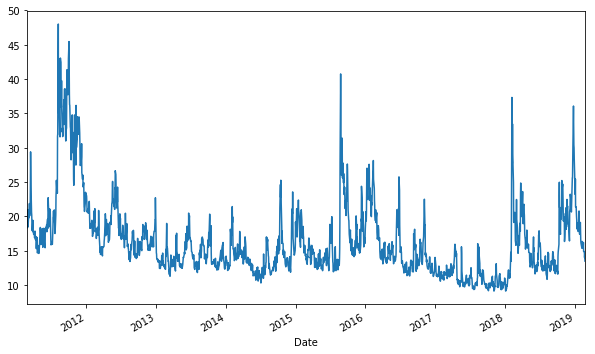

In [56]:
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

In [57]:
split_date = pd.Timestamp('2018-01-01')
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]

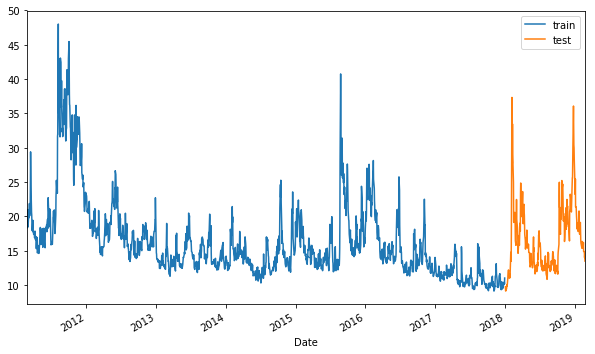

In [58]:
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [59]:
scaler=MinMaxScaler(feature_range=(-1,1))

In [76]:
# scale train and test data to [-1, 1]

train_sc=scaler.fit_transform(train.values.reshape(-1,1))
test_sc=scaler.transform(test.values.reshape(-1,1))

In [103]:
X_train=train_sc[:-1]
y_train=train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Simple ANN for Time Series Forecasting
https://towardsdatascience.com/an-introduction-on-time-series-forecasting-with-simple-neura-networks-lstm-f788390915b

In [107]:
nn_model=Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
#input_dim argument to the first layer
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop=EarlyStopping(monitor='loss', patience=2, verbose=1) 
# Stop training when a monitored loss has stopped improving.
# patience=2, indicate number of epochs with no improvement after which training will be stopped.
history=nn_model.fit(X_train, y_train, epochs=100, batch_size=1,
                    verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1723/1723 [==============================] - 3s 2ms/step - loss: 0.0130
Epoch 2/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 3/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 4/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 5/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 6/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 7/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 8/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 9/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 10/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 11/100
1723/1723 [==============================] - 2s 1ms/step - loss: 0.0061
Epoch 12/100
1723/1723 [==============================] - 2s 1ms/step - lo

In [113]:
y_pred_test_nn=nn_model.predict(X_test)
y_train_pred_nn=nn_model.predict(X_train)
print("The R2 score on the Train Set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print('The R2 Score on the Test Set is:\t{:0.3f}'.format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train Set is:	0.907
The R2 Score on the Test Set is:	0.801


# LSTM

In [114]:
train_sc_df=pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=['Y'], index=test.index)

When constructing LSTM, we will use pandas shift function that shifts the entire column by 1. In the below code snippet, we shifted the column down by 1. Then we will need to convert all our input variables to be represented in a 3D vector form

In [116]:
for s in range(1,2):
    train_sc_df['X_{}'.format(s)]= train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)]= test_sc_df['Y'].shift(s)

In [118]:
train_sc_df['X_1'].head(5)

Date
2011-02-25         NaN
2011-02-28   -0.481215
2011-03-01   -0.525991
2011-03-02   -0.389089
2011-03-03   -0.405044
Name: X_1, dtype: float64

In [142]:
X_train=train_sc_df.dropna().drop('Y', axis=1)
y_train=train_sc_df.dropna().drop('X_1', axis=1)

X_test=test_sc_df.dropna().drop('Y',axis=1)
y_test=test_sc_df.dropna().drop('X_1', axis=1)

### Shaping iput variables to 3D vector form

In [143]:
X_train= X_train.values
y_train= y_train.values
# Converted dataframes to array
X_test= X_test.values
y_test= y_test.values

X_train_lmse= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train Shape:', X_train_lmse.shape)
print('Test Shape:', X_test_lmse.shape)

Train Shape: (1723, 1, 1)
Test Shape: (286, 1, 1)


The LSTM has a visible layer with 1 input.
A hidden layer with 7 LSTM neurons.
An output layer that makes a single value prediction.
The relu activation function is used for the LSTM neurons.
The LSTM is trained for 100 epochs and a batch size of 1 is used.

In [144]:
lstm_model=Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]),
                   activation='relu', kernel_initializer='lecun_uniform',
                   return_sequences=False))
# kernel_initializer used to initiate weights( random uniform, normal, e.g.)
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop=EarlyStopping(monitor='loss',patience=2, verbose=1)
history_lstm_model= lstm_model.fit(X_train_lmse, y_train, epochs=100,
                                  batch_size=1, verbose=1, shuffle=False,
                                  callbacks=[early_stop])

Epoch 1/100
1723/1723 [==============================] - 9s 5ms/step - loss: 0.0204
Epoch 2/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0109
Epoch 3/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0080
Epoch 4/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0067
Epoch 5/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0063
Epoch 6/100
1723/1723 [==============================] - 7s 4ms/step - loss: 0.0061
Epoch 7/100
1723/1723 [==============================] - 8s 4ms/step - loss: 0.0060
Epoch 8/100
1723/1723 [==============================] - 8s 4ms/step - loss: 0.0060
Epoch 9/100
1723/1723 [==============================] - 8s 4ms/step - loss: 0.0060
Epoch 10/100
1723/1723 [==============================] - 8s 4ms/step - loss: 0.0060
Epoch 11/100
1723/1723 [==============================] - 8s 4ms/step - loss: 0.0060
Epoch 12/100
1723/1723 [==============================] - 8s 4ms/step - lo

In [145]:
y_pred_test_lstm= lstm_model.predict(X_test_lmse)
y_train_pred_lstm= lstm_model.predict(X_train_lmse)
print('The R2 Score on the Train Set is:\t{:0.3f}'.format(r2_score(y_train, y_train_pred_lstm)))
print('The R2 Score on the test set is:\t{:0.3f}'.format(r2_score(y_test, y_pred_test_lstm)))

The R2 Score on the Train Set is:	0.905
The R2 Score on the test set is:	0.788


In [151]:
nn_test_mse=nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse=lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

286/286 [==============================] - 0s 974us/step
NN: 0.012389
LSTM: 0.013216


In [149]:
lstm_model.metrics_names

['loss']

### Making Predictions

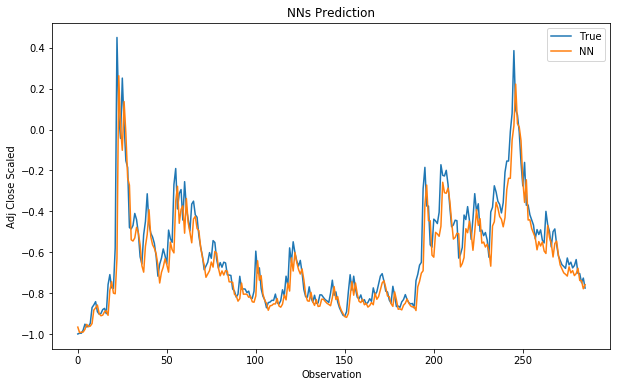

In [153]:
nn_y_pred_test= nn_model.predict(X_test)
lstm_y_pred_test= lstm_model.predict(X_test_lmse)

plt.figure(figsize=(10,6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title('NNs Prediction')
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show()

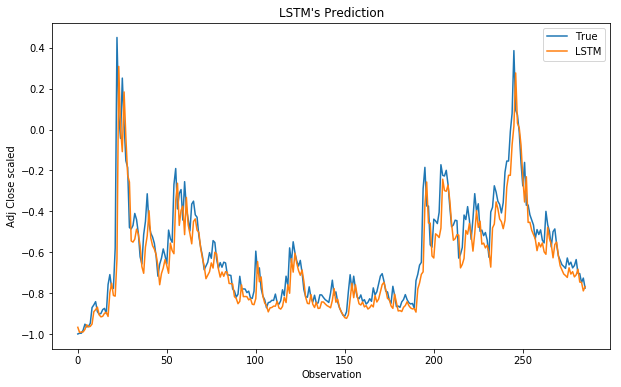

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();